In [6]:
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
from konlpy.tag import Mecab
mecab = Mecab()

#import lightgbm as lgb

import tensorflow as tf
import keras

Using TensorFlow backend.


In [7]:
pd.options.display.max_rows = 1000

In [8]:
df = pd.read_csv('./data/train.csv')

In [9]:
def parse_sentence(sentence):
    prev_word, prev_pos = '', ''
    nouns = []
    words = []
    etc = []
    buff = ''
    ret = []
    condition = False
    idx, condidx = 0, 0
    
    if sentence[:4] == '(광고)':
        words.append('(광고)')
        nouns.append('(광고)')
        sentence = sentence[4:]

    for word, pos in mecab.pos(sentence):

        if pos in ('SF') or pos[:1] in ('J'):
            # 은/는/이/가/. 등
            prev_word, prev_pos = '', ''
            continue

        if pos[:1] == 'N' and prev_pos[:1] == 'S':
            # 1억, 1천만원 등
            word = re.sub('[억천만]', '', word)
            if len(word) == 0:
                continue

        if pos[:1] == 'S':
            word = re.sub('[(:)]', '', word)
            word = re.sub('[0-9.X]+', 'X', word)

        # 조건절 판단
        if prev_pos[-3:] == 'ETM' and word in ['분','고객','개인','사업자','이','대상','당신','직원','VIP', '자','분도','전문직','신용자','외국인','본인','임직원','부모','회계사','귀하','투자자','분과']:
            condition = True  
        elif pos[:1] == 'N':
            if word[:2] in ('경우', '필요', '라면', '다면'): # 경우, 필요 단어 등장 시 조건절로 판단
                condition = True
        elif pos[-2:] == 'EC':
            # 여도, 라도, 라면, 면
            if word[-1:] in ('면', '도') or word[-2:] in ('도록'):
                condition = True

        if pos[:1] == 'E':
            buff += word
        #elif pos[:1] == 'N' and prev_pos[:1] == 'N' and len(word) == 1:
        #    buff += word
        elif pos[:1] == 'S' and prev_pos[:1] == 'S' and word[:1] in 'X0123456789%.-': #('%', '.', '-'):
            if buff[-1:] in ('시', '원', '%'):
                words.append(buff)
                buff = ''
            buff += word
            #buff += re.sub('[0-9.X]+', 'X', word)
            #buff = re.sub('[0-9.X]+', 'X', buff)
        elif pos[:1] == 'N' and prev_pos[:1] == 'S' and len(buff) > 0 and word in ('시', '분', '초', '시간'):
            buff = re.sub('시', '', buff)
            buff += '시'
        elif pos[:1] == 'N' and prev_pos[:1] == 'S' and len(buff) > 0 and word in ('년', '월', '일', '개월'):
            buff = re.sub('일', '', buff)
            buff += '일'
        elif pos[:1] == 'N' and prev_pos[:1] == 'S' and len(buff) > 0 and word in ('원'):
            buff = re.sub('원', '', buff)
            buff += '원'
        elif pos[:1] == 'N' and prev_pos[:1] == 'S' and len(buff) > 0 and word in ('건', '배', 'pt'):
            buff += word
        else:
            if len(buff) > 0:
                buff = re.sub('[0-9.X]+', 'X', buff)
                buff = re.sub('[-]+', '-', buff)
                buff = re.sub('[X]+', 'X', buff)
                if True: #buff != 'X':
                    words.append(buff)
                    # M, N 경우만 저장해보자
                    if prev_pos[:1] in ('N'):  # 'M', 
                        nouns.append(buff)
            buff = word
            prev_word, prev_pos = word, pos

        if pos[-2:] in ('EF'): # and word[0][-1:] in ['요', '다']:
            # words가 꼭 명사를 뜻하는 게 아니고 특색있는 키워드 모두를 포함
            if len(buff) > 0:
                words.append(buff)
            buff = ''
            # 문장의 끝을 구분
            words.append('(절취선)')
            ret.append([word, condition, words, nouns])
            idx += 1
            if condition: condidx += 1
            nouns = []
            words = []
            condition = False
    if len(buff) > 0:
        words.append(buff)
    if len(words) > 0:
        ret.append([word, condition, words, nouns])
        #ret.append([word, condition, nouns])
        idx += 1
        if condition: condidx += 1
    etc.append(condidx / idx)
    return ret, etc

In [10]:
smishings = []
normals = []
idx = 0
for idx, item in df.iterrows():
    #print(item.text)
    splited, etc = parse_sentence(item.text)
    etc.append(np.log(len(item.text))/8)  # 문장 전체의 길이
    etc.append(np.log(len(splited))/4)  # 문장의 개수
    splited.append(etc)
    splited.append(item.id)
    #splited = m.parse(item.text).split()
    if item.smishing == 1:
        smishings.append(splited)
    else:
        normals.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1
#     if idx > 20000:
#         break

2020-01-08 22:36:17.106886 0
2020-01-08 22:37:26.995470 100000
2020-01-08 22:39:13.700527 200000


In [11]:
# 스미싱에만 등장하는 문자들 : smish_target_words
NORM_THRESHOLD, SMISH_THRESHOLD = 1000, 2
norm_dict = {}
for item in [x for normal in normals for row in normal if type(row) == list and len(row) > 3 for x in row[3]]:
    if item in norm_dict:
        norm_dict[item] += 1
    else:
        norm_dict[item] = 1
norm_filter_words = {x:norm_dict.get(x) for x in norm_dict if norm_dict.get(x) > NORM_THRESHOLD}

smish_dict = {}
for item in [x for smishing in smishings for row in smishing if type(row) == list and len(row) > 3 for x in row[3]]:
    if item in smish_dict:
        smish_dict[item] += 1
    else:
        smish_dict[item] = 1
smish_filter_words = {x:smish_dict.get(x) for x in smish_dict if smish_dict.get(x) > SMISH_THRESHOLD}
        
word_only_in_smishings = [word for word in smish_dict if word not in norm_filter_words]
word_only_in_normals = [word for word in norm_dict if word not in smish_filter_words]

norm_target_words = {x:norm_dict.get(x) for x in word_only_in_normals if norm_dict.get(x) > NORM_THRESHOLD}
smish_target_words = {x:smish_dict.get(x) for x in word_only_in_smishings if smish_dict.get(x) > SMISH_THRESHOLD}
print('selected normal-like words count:', len(norm_target_words))
print('selected smishing-like words count:', len(smish_target_words))

selected normal-like words count: 223
selected smishing-like words count: 1698


In [12]:
smishing_word_cnt = []
normal_word_cnt = []
for smishing in smishings:
    notarget_word_list = [x for row in smishing[:-2] for x in row[3] if x in norm_target_words]
    target_word_list = [x for row in smishing[:-2] for x in row[3] if x in smish_target_words]
    smishing.insert(-2, notarget_word_list)
    smishing.insert(-2, target_word_list)
    smishing_word_cnt.append(len(target_word_list))
for normal in normals:
    notarget_word_list = [x for row in normal[:-2] for x in row[3] if x in norm_target_words]
    target_word_list = [x for row in normal[:-2] for x in row[3] if x in smish_target_words]
    normal.insert(-2, notarget_word_list)
    normal.insert(-2, target_word_list)
    normal_word_cnt.append(len(target_word_list))

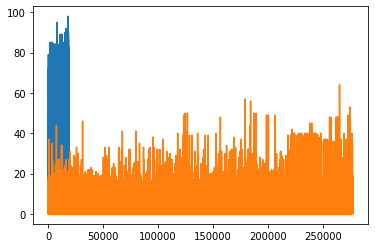

In [13]:
#plt.subplots(ncols=2)
plt.plot(smishing_word_cnt)
plt.plot(normal_word_cnt)

In [14]:
[print(x) for x in normals[2]]

['십니까', False, ['안녕', '하십니까', '(절취선)'], ['안녕']]
['입니다', False, ['고객', '님', 'X', '은행', '입니다', '(절취선)'], ['고객', '은행']]
['입니다', False, ['금일', '납부', '하셔야', '할', '금액', 'X원', '입니다', '(절취선)'], ['금일', '납부', '금액']]
['합니다', False, ['감사', '합니다', '(절취선)'], ['감사']]
['으십시오', False, ['새해', '복', '많이', '받으십시오', '(절취선)'], ['새해', '복']]
['올림', False, ['X', '은행', '옥포', 'X', '올림'], ['은행', '옥포']]
['옥포']
[]
[0.0, 0.5493061443340549, 0.44793986730701374]
2


[None, None, None, None, None, None, None, None, None, None]

In [15]:
class wordCounter():
    def __init__(self):
        self.word_bank = {}
    
    def add_bucket(self, bucket_name):
        self.word_bank[bucket_name] = {}
        
    def add_list(self, bucket_name, word_list:[]):
        bucket = self.word_bank[bucket_name]
        for keyword in word_list:
            if keyword in bucket:
                bucket[keyword] += 1
            else:
                bucket[keyword] = 1
                
    def get_counts(self, bucket_name):
        return self.word_bank[bucket_name]

In [16]:
wc = wordCounter()
wc.add_bucket('conditioned')
wc.add_bucket('general')
wc.add_bucket('whole')
wc.add_bucket('notargets')
wc.add_bucket('targets')

LEN_OF_OTHERS = 4

for normal in normals:
    for item in normal[:-LEN_OF_OTHERS]:
        wc.add_list('whole', item[2])
        if item[1] == True:
            wc.add_list('conditioned', item[3])
        else:
            wc.add_list('general', item[3])
    wc.add_list('notargets', normal[-4])
    wc.add_list('targets', normal[-3])

for smishing in smishings:
    for item in smishing[:-LEN_OF_OTHERS]:
        wc.add_list('whole', item[2])
        if item[1] == True:
            wc.add_list('conditioned', item[3])
        else:
            wc.add_list('general', item[3])
    wc.add_list('notargets', smishing[-4])
    wc.add_list('targets', smishing[-3])

In [17]:
conditioned_df = pd.Series(wc.get_counts('conditioned'))
general_df = pd.Series(wc.get_counts('general'))
whole_df = pd.Series(wc.get_counts('whole'))
notargets_df = pd.Series(wc.get_counts('notargets'))
targets_df = pd.Series(wc.get_counts('targets'))

# 글자가 2개 이상인 것만 모아보자
conditioned_df = conditioned_df[conditioned_df.index.map(len) > 1]  # M 만 포함시켰으므로.. 길이 2이상인것만
general_df = general_df[general_df.index.map(len) > 1]  # M 만 포함시켰으므로.. 길이 2이상인것만
# targets_df 일단 생략

# 3번 이상 출현한 것만 모아보자
#conditioned_df = conditioned_df[conditioned_df.sort_values() > 2]
#general_df = general_df[general_df.sort_values() > 2]

In [18]:
general_dic = general_df[general_df > 1].sort_values(ascending=False)
general_dic = general_dic.reset_index()['index'].to_dict()
general_vocab = {general_dic.get(k):k for k in general_dic}

In [19]:
conditioned_dic = conditioned_df[conditioned_df > 1].sort_values(ascending=False)
conditioned_dic = conditioned_dic.reset_index()['index'].to_dict()
conditioned_vocab = {conditioned_dic.get(k):k for k in conditioned_dic}

In [20]:
whole_dic = whole_df[whole_df > 1].sort_values(ascending=False)
whole_dic = whole_dic.reset_index()['index'].to_dict()
whole_vocab = {whole_dic.get(k):k for k in whole_dic}

In [21]:
notargets_dic = notargets_df[notargets_df > 1].sort_values(ascending=False)
notargets_dic = notargets_dic.reset_index()['index'].to_dict()
notargets_vocab = {notargets_dic.get(k):k for k in notargets_dic}

In [22]:
targets_dic = targets_df[targets_df > 1].sort_values(ascending=False)
targets_dic = targets_dic.reset_index()['index'].to_dict()
targets_vocab = {targets_dic.get(k):k for k in targets_dic}

In [23]:
# smishing cases; length of vocab when it's out of vocab
tidf_conditioned = []
tidf_general = []
tidf_whole = []
tidf_notargets = []
tidf_targets = []
tidf_etc = []

cond_vocabsize = len(conditioned_vocab)
gen_vocabsize = len(general_vocab)
whole_vocabsize = len(whole_vocab)
notargets_vocabsize = len(notargets_vocab)
targets_vocabsize = len(targets_vocab)

print('size of vocab (conditioned, general, whole, targets):', cond_vocabsize, gen_vocabsize, whole_vocabsize, targets_vocabsize)

# 문장별 bag of word를 제외한 항목의 수 : notargets, targets, etc, idx
LEN_OF_OTHERS = 4
for msg in normals:
    tidf_conditioned.append([conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for row in msg[:-LEN_OF_OTHERS] if row[1] == True for x in row[3]])
    tidf_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-LEN_OF_OTHERS] if row[1] == False for x in row[3]])
    tidf_whole.append([whole_vocab.get(x) if x in whole_vocab else whole_vocabsize for row in msg[:-LEN_OF_OTHERS] for x in row[2]])
    tidf_notargets.append([notargets_vocab.get(x) if x in notargets_vocab else notargets_vocabsize for x in msg[-4]])
    tidf_targets.append([targets_vocab.get(x) if x in targets_vocab else targets_vocabsize for x in msg[-3]])
    tidf_etc.append(msg[-2])
for msg in smishings:
    tidf_conditioned.append([conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for row in msg[:-LEN_OF_OTHERS] if row[1] == True for x in row[3]])
    tidf_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-LEN_OF_OTHERS] if row[1] == False for x in row[3]])
    tidf_whole.append([whole_vocab.get(x) if x in whole_vocab else whole_vocabsize for row in msg[:-LEN_OF_OTHERS] for x in row[2]])
    tidf_notargets.append([notargets_vocab.get(x) if x in notargets_vocab else notargets_vocabsize for x in msg[-4]])
    tidf_targets.append([targets_vocab.get(x) if x in targets_vocab else targets_vocabsize for x in msg[-3]])
    tidf_etc.append(msg[-2])

size of vocab (conditioned, general, whole, targets): 9070 15877 38696 1698


In [24]:
len(tidf_conditioned), len(tidf_general), len(tidf_etc), len(tidf_targets)

(295945, 295945, 295945, 295945)

In [25]:
convec_size = max([len(x) for x in tidf_conditioned])
genvec_size = max([len(x) for x in tidf_general])
whlvec_size = max([len(x) for x in tidf_whole])
notgtvec_size = max([len(x) for x in tidf_notargets])
tgtvec_size = max([len(x) for x in tidf_targets])

# 문장 내 인식한 단어의 개수의 최대값 (문장의 길이가 길수록 크겠지..)
print('conditioned vector minimum size:', convec_size)
print('general vector minimum size:', genvec_size)
print('whole vector minimum size:', whlvec_size)
print('notarget vector minimum size:', notgtvec_size)
print('target vector minimum size:', tgtvec_size)

conditioned vector minimum size: 260
general vector minimum size: 333
whole vector minimum size: 508
notarget vector minimum size: 43
target vector minimum size: 98


In [26]:
# 훈련용, 훈련검증용, 결과검증용 분리
tidf_conditioned = np.array(tidf_conditioned)
tidf_general = np.array(tidf_general)
tidf_whole = np.array(tidf_whole)
tidf_notargets = np.array(tidf_notargets)
tidf_targets = np.array(tidf_targets)
tidf_etc = np.array(tidf_etc)
tidf_label = np.array([1 if x >= len(normals) else 0 for x in range(tidf_conditioned.shape[0])])

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

class DataGenerator(keras.utils.Sequence):
    def __init__(self, tidf_cond_train, tidf_gen_train, tidf_whole_train, tidf_notargets_train, tidf_targets_train, tidf_etc_train, tidf_label_train, normal_size=160, smishing_size=160, convec_size=350, genvec_size=470, whlvec_size=500, notgtvec_size=100, tgtvec_size=100):
        self.convec_size = convec_size  # including 0 paddings
        self.genvec_size = genvec_size  # including 0 paddings
        self.whlvec_size = whlvec_size  # including 0 paddings
        self.notgtvec_size = notgtvec_size  # including 0 paddings
        self.tgtvec_size = tgtvec_size  # including 0 paddings
        self.tidf_cond_train_normal = pad_sequences(tidf_cond_train[tidf_label_train == 0], maxlen=self.convec_size, padding='pre')
        self.tidf_gen_train_normal = pad_sequences(tidf_gen_train[tidf_label_train == 0], maxlen=self.genvec_size, padding='pre')
        self.tidf_whole_train_normal = pad_sequences(tidf_whole_train[tidf_label_train == 0], maxlen=self.whlvec_size, padding='pre')
        self.tidf_targets_train_normal = pad_sequences(tidf_targets_train[tidf_label_train == 0], maxlen=self.tgtvec_size, padding='pre')
        self.tidf_notargets_train_normal = pad_sequences(tidf_notargets_train[tidf_label_train == 0], maxlen=self.notgtvec_size, padding='pre')
        self.tidf_etc_train_normal = tidf_etc_train[tidf_label_train == 0]
        self.tidf_cond_train_smishing = pad_sequences(tidf_cond_train[tidf_label_train == 1], maxlen=self.convec_size, padding='pre')
        self.tidf_gen_train_smishing = pad_sequences(tidf_gen_train[tidf_label_train == 1], maxlen=self.genvec_size, padding='pre')
        self.tidf_whole_train_smishing = pad_sequences(tidf_whole_train[tidf_label_train == 1], maxlen=self.whlvec_size, padding='pre')
        self.tidf_notargets_train_smishing = pad_sequences(tidf_notargets_train[tidf_label_train == 1], maxlen=self.notgtvec_size, padding='pre')
        self.tidf_targets_train_smishing = pad_sequences(tidf_targets_train[tidf_label_train == 1], maxlen=self.tgtvec_size, padding='pre')
        self.tidf_etc_train_smishing = tidf_etc_train[tidf_label_train == 1]
        self.sample_size_normal = normal_size
        self.sample_size_smishing = smishing_size
        self.train_size_normal = len(self.tidf_cond_train_normal)
        self.train_size_smishing = len(self.tidf_cond_train_smishing)
#         self.sample_size = normal_size + smishing_size
#         self.num_batch = int(np.ceil(len(self.tidf_cond_train_normal) // self.sample_size / 10))
        self.num_batch_normal = int(np.ceil(self.train_size_normal / self.sample_size_normal))
        self.num_batch_smishing = int(np.ceil(self.train_size_smishing / self.sample_size_smishing))
        self.normal_train_index = np.array(range(self.train_size_normal))
        self.smishing_train_index = np.array(range(self.train_size_smishing))
        print(f"num_batch_normal: {self.num_batch_normal}, num_batch_smishing: {self.num_batch_smishing}")
    
    def __len__(self):
        return max(self.num_batch_normal, self.num_batch_smishing)
    
    def __getitem__(self, index):
        # sequencial sampling
        normal_idx, smishing_idx = index % self.num_batch_normal, index % self.num_batch_smishing
        #print(f"normal_idx: {normal_idx}, smishing_idx: {smishing_idx}")
        normal_sampling = self.normal_train_index // self.sample_size_normal == normal_idx
#         normal_sampling = np.random.choice(len(self.tidf_cond_train_normal), self.normal_sample_size)
        normal_cond_sample = self.tidf_cond_train_normal[normal_sampling]
        normal_gen_sample = self.tidf_gen_train_normal[normal_sampling]
        normal_whole_sample = self.tidf_whole_train_normal[normal_sampling]
        normal_notargets_sample = self.tidf_notargets_train_normal[normal_sampling]
        normal_targets_sample = self.tidf_targets_train_normal[normal_sampling]
        normal_etc_sample = self.tidf_etc_train_normal[normal_sampling]
        smishing_sampling = self.smishing_train_index // self.sample_size_smishing == smishing_idx
#         smishing_sampling = np.random.choice(len(self.tidf_cond_train_smishing), self.smishing_sample_size)
        smishing_cond_sample = self.tidf_cond_train_smishing[smishing_sampling]
        smishing_gen_sample = self.tidf_gen_train_smishing[smishing_sampling]
        smishing_whole_sample = self.tidf_whole_train_smishing[smishing_sampling]
        smishing_notargets_sample = self.tidf_notargets_train_smishing[smishing_sampling]
        smishing_targets_sample = self.tidf_targets_train_smishing[smishing_sampling]
        smishing_etc_sample = self.tidf_etc_train_smishing[smishing_sampling]
        sample_cond_train = np.concatenate([normal_cond_sample, smishing_cond_sample])
        sample_gen_train = np.concatenate([normal_gen_sample, smishing_gen_sample])
        sample_whole_train = np.concatenate([normal_whole_sample, smishing_whole_sample])
        sample_notargets_train = np.concatenate([normal_notargets_sample, smishing_notargets_sample])
        sample_targets_train = np.concatenate([normal_targets_sample, smishing_targets_sample])
        sample_etc_train = np.concatenate([normal_etc_sample, smishing_etc_sample])
        sample_label_train = [1 if x >= len(normal_cond_sample) else 0 for x in range(len(sample_cond_train))]
        return [sample_cond_train, sample_gen_train, sample_whole_train, sample_notargets_train, sample_targets_train, sample_etc_train], sample_label_train
#        return [sample_gen_train, sample_etc_train], sample_label_train

    def on_epoch_end(self):
        pass

In [28]:
TRAIN_RATIO, VALID_RATIO = 0.6, 0.8
np.random.seed(0)
split = np.random.rand(tidf_conditioned.shape[0])
tidf_cond_train = tidf_conditioned[split < TRAIN_RATIO]
tidf_cond_valid = tidf_conditioned[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_cond_test = tidf_conditioned[split >= VALID_RATIO]

tidf_gen_train = tidf_general[split < TRAIN_RATIO]
tidf_gen_valid = tidf_general[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_gen_test = tidf_general[split >= VALID_RATIO]

tidf_whole_train = tidf_whole[split < TRAIN_RATIO]
tidf_whole_valid = tidf_whole[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_whole_test = tidf_whole[split >= VALID_RATIO]

tidf_notargets_train = tidf_notargets[split < TRAIN_RATIO]
tidf_notargets_valid = tidf_notargets[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_notargets_test = tidf_notargets[split >= VALID_RATIO]

tidf_targets_train = tidf_targets[split < TRAIN_RATIO]
tidf_targets_valid = tidf_targets[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_targets_test = tidf_targets[split >= VALID_RATIO]

tidf_etc_train = tidf_etc[split < TRAIN_RATIO]
tidf_etc_valid = tidf_etc[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_etc_test = tidf_etc[split >= VALID_RATIO]

tidf_label_train = tidf_label[split < TRAIN_RATIO]
tidf_label_valid = tidf_label[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_label_test = tidf_label[split >= VALID_RATIO]

tidf_cond_train.shape, tidf_cond_valid.shape #, tidf_cond_test.shape

((177533,), (59281,))

In [29]:
# conditioned vector minimum size: 260
# general vector minimum size: 333
# whole vector minimum size: 508
# notarget vector minimum size: 43
# target vector minimum size: 98

#26, 33, 50, 4, 10 * 0.6

num_predictive_factors1, num_predictive_factors2, num_predictive_factors3, num_predictive_factors4, num_predictive_factors5 = 16, 20, 30, 2, 6
n_cond, n_gen, n_whole, n_notargets, n_targets, n_etc = convec_size, genvec_size, whlvec_size, notgtvec_size, tgtvec_size, len(tidf_etc_train[0])
cond_input = keras.layers.Input(shape=(n_cond,), name='Cond')
gen_input = keras.layers.Input(shape=(n_gen,), name='General')
whole_input = keras.layers.Input(shape=(n_whole,), name='Whole')
notargets_input = keras.layers.Input(shape=(n_notargets,), name='NoTargets')
targets_input = keras.layers.Input(shape=(n_targets,), name='Targets')
etc_input = keras.layers.Input(shape=(n_etc,), name='Etc')

cond_vec_mlp = keras.layers.Embedding(cond_vocabsize + 1, num_predictive_factors1, )(cond_input)
cond_vec_mlp = keras.layers.Flatten(name='Flattenconds-MLP')(cond_vec_mlp)
cond_vec_mlp = keras.layers.Dropout(0.3)(cond_vec_mlp)

gen_vec_mlp = keras.layers.Embedding(gen_vocabsize + 1, num_predictive_factors2, )(gen_input)
gen_vec_mlp = keras.layers.Flatten(name='Flattengens-MLP')(gen_vec_mlp)
gen_vec_mlp = keras.layers.Dropout(0.3)(gen_vec_mlp)

whole_vec_mlp = keras.layers.Embedding(whole_vocabsize + 1, num_predictive_factors3, )(whole_input)
whole_vec_mlp = keras.layers.Flatten(name='Flattenwhls-MLP')(whole_vec_mlp)
whole_vec_mlp = keras.layers.Dropout(0.3)(whole_vec_mlp)

notargets_vec_mlp = keras.layers.Embedding(notargets_vocabsize + 1, num_predictive_factors4, )(notargets_input)
notargets_vec_mlp = keras.layers.Flatten(name='FlattenNotgts-MLP')(notargets_vec_mlp)
notargets_vec_mlp = keras.layers.Dropout(0.3)(notargets_vec_mlp)

targets_vec_mlp = keras.layers.Embedding(targets_vocabsize + 1, num_predictive_factors5, )(targets_input)
targets_vec_mlp = keras.layers.Flatten(name='Flattentgts-MLP')(targets_vec_mlp)
targets_vec_mlp = keras.layers.Dropout(0.3)(targets_vec_mlp)

concat_mlp = keras.layers.merge.concatenate([cond_vec_mlp, gen_vec_mlp, whole_vec_mlp, notargets_vec_mlp, targets_vec_mlp, etc_input])
concat_dropout_mlp = keras.layers.Dropout(0.3)(concat_mlp)

dense = keras.layers.Dense(28, kernel_regularizer=keras.regularizers.l2(0.0025), name='FullyConnected-1', activation='relu')(concat_dropout_mlp)
dropout_1 = keras.layers.Dropout(0.3, name='Dropout-1')(dense)

#dense_2 = keras.layers.Dense(DENSE2, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-2', activation='relu')(dropout_1)
#dropout_2 = keras.layers.Dropout(0.3, name='Dropout-2')(dense_2)

#dense_3 = keras.layers.Dense(DENSE3, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-3', activation='relu')(dropout_2)
#dropout_3 = keras.layers.Dropout(0.3, name='Dropout-3')(dense_3)

dense_4 = keras.layers.Dense(28, kernel_regularizer=keras.regularizers.l2(0.0025), name='FullyConnected-4', activation='relu')(dropout_1)
pred_mlp = keras.layers.Dense(1, activation='sigmoid', name='Activation')(dense_4)

model = keras.Model(inputs=[cond_input, gen_input, whole_input, notargets_input, targets_input, etc_input ], output=pred_mlp)  #  etc_input
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])
#model.compile(optimizer=keras.optimizers.Adamax(lr=1e-3), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/xikizima/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("Ac...)`


In [33]:
train_gen = DataGenerator(tidf_cond_train, tidf_gen_train, tidf_whole_train, tidf_notargets_train, tidf_targets_train, tidf_etc_train, tidf_label_train, 160, 160, convec_size, genvec_size, whlvec_size, notgtvec_size, tgtvec_size)
valid_gen = DataGenerator(tidf_cond_valid, tidf_gen_valid, tidf_whole_valid, tidf_notargets_valid, tidf_targets_valid, tidf_etc_valid, tidf_label_valid, 1000, 1000, convec_size, genvec_size, whlvec_size, notgtvec_size, tgtvec_size)

history = model.fit_generator(generator=train_gen,
                             epochs = 100,
#                              use_multiprocessing=True,
#                               workers=3,
                             validation_data=valid_gen,
                             verbose=1)

num_batch_normal: 1039, num_batch_smishing: 71
num_batch_normal: 56, num_batch_smishing: 4
Epoch 1/100
1039/1039 [==============================] - 262s 252ms/step - loss: 0.0082 - binary_crossentropy: 0.0025 - acc: 0.9996 - val_loss: 0.0095 - val_binary_crossentropy: 0.0045 - val_acc: 0.9989
Epoch 2/100
1039/1039 [==============================] - 263s 253ms/step - loss: 0.0074 - binary_crossentropy: 0.0024 - acc: 0.9997 - val_loss: 0.0107 - val_binary_crossentropy: 0.0059 - val_acc: 0.9985
Epoch 3/100
1039/1039 [==============================] - 259s 250ms/step - loss: 0.0066 - binary_crossentropy: 0.0021 - acc: 0.9997 - val_loss: 0.0107 - val_binary_crossentropy: 0.0061 - val_acc: 0.9986
Epoch 4/100
1039/1039 [==============================] - 259s 249ms/step - loss: 0.0060 - binary_crossentropy: 0.0019 - acc: 0.9997 - val_loss: 0.0085 - val_binary_crossentropy: 0.0048 - val_acc: 0.9988
Epoch 5/100
1039/1039 [==============================] - 259s 250ms/step - loss: 0.0054 - binary_

1039/1039 [==============================] - 260s 251ms/step - loss: 0.0017 - binary_crossentropy: 4.1086e-04 - acc: 0.9999 - val_loss: 0.0059 - val_binary_crossentropy: 0.0045 - val_acc: 0.9988
Epoch 41/100
1039/1039 [==============================] - 258s 248ms/step - loss: 0.0016 - binary_crossentropy: 3.6012e-04 - acc: 0.9999 - val_loss: 0.0063 - val_binary_crossentropy: 0.0051 - val_acc: 0.9988
Epoch 42/100
1039/1039 [==============================] - 259s 249ms/step - loss: 0.0015 - binary_crossentropy: 3.6930e-04 - acc: 0.9999 - val_loss: 0.0056 - val_binary_crossentropy: 0.0047 - val_acc: 0.9988
Epoch 43/100
1039/1039 [==============================] - 259s 249ms/step - loss: 0.0015 - binary_crossentropy: 3.5235e-04 - acc: 0.9999 - val_loss: 0.0065 - val_binary_crossentropy: 0.0047 - val_acc: 0.9988
Epoch 44/100
1039/1039 [==============================] - 260s 251ms/step - loss: 0.0016 - binary_crossentropy: 3.7419e-04 - acc: 0.9999 - val_loss: 0.0060 - val_binary_crossentropy

1039/1039 [==============================] - 259s 249ms/step - loss: 0.0012 - binary_crossentropy: 2.0013e-04 - acc: 1.0000 - val_loss: 0.0065 - val_binary_crossentropy: 0.0057 - val_acc: 0.9988
Epoch 80/100
1039/1039 [==============================] - 259s 249ms/step - loss: 9.9190e-04 - binary_crossentropy: 1.8537e-04 - acc: 1.0000 - val_loss: 0.0068 - val_binary_crossentropy: 0.0059 - val_acc: 0.9988
Epoch 81/100
1039/1039 [==============================] - 259s 249ms/step - loss: 0.0010 - binary_crossentropy: 2.0529e-04 - acc: 1.0000 - val_loss: 0.0058 - val_binary_crossentropy: 0.0049 - val_acc: 0.9988
Epoch 82/100
1039/1039 [==============================] - 259s 250ms/step - loss: 0.0011 - binary_crossentropy: 1.9494e-04 - acc: 1.0000 - val_loss: 0.0061 - val_binary_crossentropy: 0.0053 - val_acc: 0.9988
Epoch 83/100
1039/1039 [==============================] - 259s 249ms/step - loss: 0.0010 - binary_crossentropy: 1.9075e-04 - acc: 1.0000 - val_loss: 0.0066 - val_binary_crossent

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train_loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history.history['acc'], 'b', label='train_acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

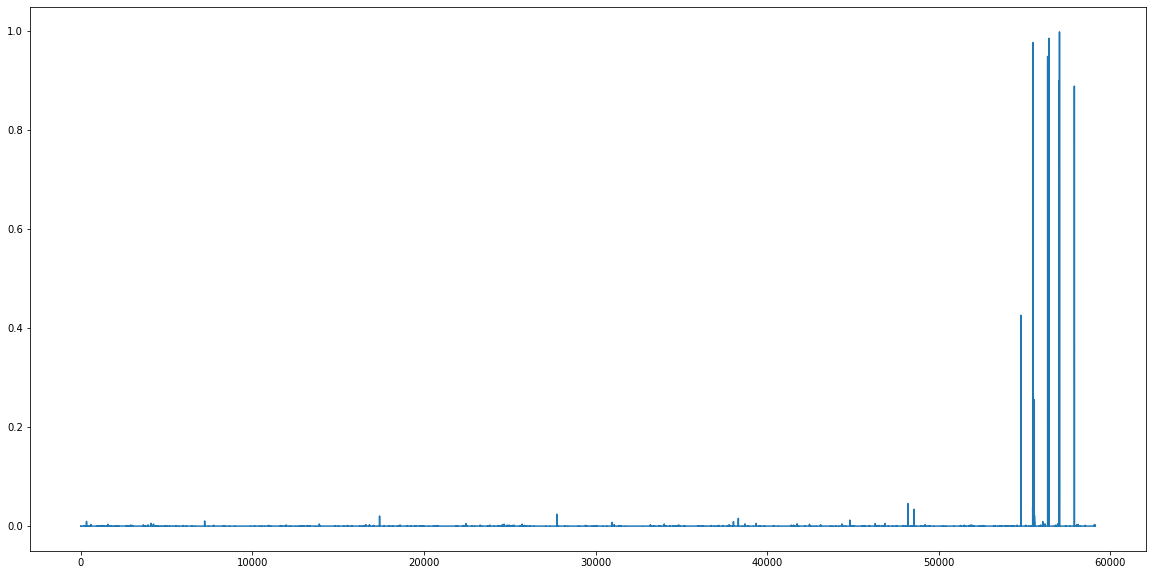

In [34]:
# 1/9 새벽 출근전
data_gen_test = pad_sequences(tidf_gen_test, maxlen=genvec_size, padding='pre')
data_cond_test = pad_sequences(tidf_cond_test, maxlen=convec_size, padding='pre')
data_whole_test = pad_sequences(tidf_whole_test, maxlen=whlvec_size, padding='pre')
data_notargets_test = pad_sequences(tidf_notargets_test, maxlen=notgtvec_size, padding='pre')
data_targets_test = pad_sequences(tidf_targets_test, maxlen=tgtvec_size, padding='pre')
data_etc_test = tidf_etc_test

pred_test = model.predict(x=[data_cond_test, data_gen_test, data_whole_test, data_notargets_test, data_targets_test, data_etc_test], batch_size=160)
gap = np.abs(tidf_label_test - pred_test.reshape([-1,]))

plt.figure(figsize=(20,10))
plt.plot(gap)

auc : 0.9999996256597623


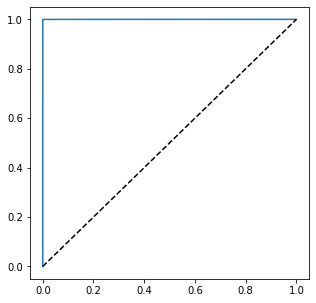

In [35]:
# 1/9 새벽 출근 전
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(tidf_label_test, pred_test)
print('auc :', auc(fpr,tpr))

plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,'-')
plt.plot([0,1],[0,1], 'k--')
plt.show()

In [ ]:
# 제출 준비

In [36]:
submit_df = pd.read_csv('./data/public_test.csv')

In [37]:
unknowns = []

idx = 0
for idx, item in submit_df.iterrows():
    splited, etc = parse_sentence(item.text)
    etc.append(np.log(len(item.text))/8)  # 문장 전체의 길이
    etc.append(np.log(len(splited))/4)  # 문장의 개수
    splited.append(etc)
    splited.append(item.id)
    unknowns.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1

2020-01-09 06:17:52.665514 0


In [38]:
for unknown in unknowns:
    notarget_word_list = [x for row in unknown[:-2] for x in row[3] if x in norm_target_words]
    target_word_list = [x for row in unknown[:-2] for x in row[3] if x in smish_target_words]
    unknown.insert(-2, notarget_word_list)
    unknown.insert(-2, target_word_list)

In [39]:
# smishing cases; length of vocab when it's out of vocab
submit_conditioned = []
submit_general = []
submit_whole = []
submit_notargets = []
submit_targets = []
submit_etc = []

cond_vocabsize = len(conditioned_vocab)
gen_vocabsize = len(general_vocab)
whole_vocabsize = len(whole_vocab)
notargets_vocabsize = len(notargets_vocab)
targets_vocabsize = len(targets_vocab)

print('size of vocab (conditioned, general):', cond_vocabsize, gen_vocabsize)
for msg in unknowns:
    submit_conditioned.append([conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for row in msg[:-4] if row[1] == True for x in row[3]])
    submit_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-4] if row[1] == False for x in row[3]])
    submit_whole.append([whole_vocab.get(x) if x in whole_vocab else whole_vocabsize for row in msg[:-4] for x in row[2]])
    submit_notargets.append([notargets_vocab.get(x) if x in notargets_vocab else notargets_vocabsize for x in msg[-4]])
    submit_targets.append([targets_vocab.get(x) if x in targets_vocab else targets_vocabsize for x in msg[-3]])
    submit_etc.append(msg[-2])

size of vocab (conditioned, general): 9070 15877


In [40]:
data_submit_conditioned = pad_sequences(submit_conditioned, maxlen=convec_size, padding='pre')
data_submit_general = pad_sequences(submit_general, maxlen=genvec_size, padding='pre')
data_submit_whole = pad_sequences(submit_whole, maxlen=whlvec_size, padding='pre')
data_submit_notargets = pad_sequences(submit_notargets, maxlen=notgtvec_size, padding='pre')
data_submit_targets = pad_sequences(submit_targets, maxlen=tgtvec_size, padding='pre')
data_submit_etc = np.array(submit_etc)

In [41]:
pred_y = model.predict(x=[data_submit_conditioned, data_submit_general, data_submit_whole, data_submit_notargets, data_submit_targets, data_submit_etc], verbose=1)

1626/1626 [==============================] - 0s 129us/step


In [42]:
pred_y[pred_y > 1.0] = 1.0

In [43]:
submit_df['smishing'] = np.abs(pred_y)

In [44]:
submit_df[['id', 'smishing']].to_csv('./data/submission_20200109_1.csv', index=False)

In [ ]:
# 일반/컨디션 문장의 경우.. 명사만 가지고 만들까?.. 의 컨셉
# 거기다 전체 문장은 모든 품사 다 포함 + 여기다 문장 사이에 구분자 추가 (절취선) + mask단어 (XXX) 추가
# 여기에 targets라는 smishing에만 주로 등장하는 단어들을 가지고 증강
# overfit 대응을 위해.. l2-reg 0.1 -> 0.25 바꾸고, 입력 embeding 사이즈를 조금 줄였더니
# 0.974222 기록 (2020.01.08 06:16) 약간 나아짐 (40번 트레이닝. 총 6시간.)
# trainning graph에 주목.. val acc는 학습이 반복될 수록 오히려 떨어지지만, 제출점수는 높아짐